In [2]:
import matplotlib.pyplot as plt
# from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import networkx as nx
import random
import time
import pandas as pd
import math
import csv
import os

t0=time.time()
###########################################################
###########################################################
# Acordate que en casa los ldata tienen que empezar con Tests/
# En la facultad va directo el nombre del archivo
############################################################
############################################################

def scan(cant,lista):
    i=0
    for x in lista:
        print(x)
        i+=1
        if i>cant:
            break
            
def Tiempo():
    t1=time.time()
    print("Esto tardó {} segundos".format(t1-t0))


def ldata(archive):
        f = open(archive)
        data = []
        for line in f:
            col = line.split("\t")
            col = [x.strip() for x in col]
            data.append(col)
        return data 
    
# Vamos a leer los archivos con esta celda. Al darle la dirección de la carpeta Datos, lo que estoy sacando
# son los nombres de todos los archivos en esa carpeta.
#--------------------------------------------------------------------------

CarpCheck=[[root,files] for root,dirs,files in os.walk("./Datos")]

##############################################################################
# Los primero dos elementos de CarpCheck no les des bola, porque son
# la mismísma carpeta en la que estás y porque el segundo es ipynb checkpoints
# Eso es algo del notebook, no del TP.
##############################################################################

# El comentario anterior era considerando que no le daba la dirección correcta
# de la carpeta con mi información al os.walk. Esta vez le estoy pasando la 
# dirección exacta, así que no es necesario hacer tanto quilombo para separar
# los nombres de los archivos. El elemento en la posición x[1] es el nombre de la carpeta


for x in CarpCheck:
    # dada = x[0].split("\\")
    Archivos_Datos = [nombre for nombre in x[1]]
    Archivos_Datos.insert(0,x[0])

# Con esto tengo los nombres de todos los archivos en la carpeta de Datos
# Archivos_Datos tiene en la primer coordenada el principio de la dirección
# de la carpeta, y el resto de elementos son los archivos en la carpeta.
# Entonces si quiero buscar el objeto voy a tener que usar:
# Archivos_Datos[0]/Archivos_Datos[1]

#----------------------------------------------------------------------------

# Leo mi archivo

# Datos = ldata("{}/{}".format(Archivos_Datos[0],Archivos_Datos[1]))

# # Levanto los valores de N y T del nombre de mi archivo. Es importante recordar que mis
# # archivos tienen nombres de la forma: Datos_Evolucion_Opinion_N=$_T=$_K=$

# N = int(Archivos_Datos[1].split("_")[3].split("=")[1])
# T = int(Archivos_Datos[1].split("_")[4].split("=")[1])
# K = float(Archivos_Datos[1].split("_")[5].split("=")[1])

# # Hagamos un gráfico de estos datos. Por lo menos del caso K=0
# # Quiero hacer un gráfico en el que se vea que las opiniones van cayendo a cero.
# # La idea es hacer una sumatoria del valor cuadrado de las opiniones de cada uno.

# # Primero me armo una lista que tenga todos los valores que están en Datos sin ese
# # espacio que está en la primer coordenada. También estaría bueno pasar los strings
# # a floats.

# Opiniones = []
# for fila in Datos[5:len(Datos)]:
#     # Arranco desde 5 porque las primeras son títulos y las matrices de Adyacencia y Superposicion
#     fila2 = [float(x) for x in fila[1:len(fila)]]
#     Opiniones.append(fila2)
#     # Debería haber una forma más compacta de hacer esto. Quizás podría hacer una función de esto.
#     # La otra es meter un espacio en los títulos también, para al levantar datos eliminar
#     # eso de una también. Y luego el mismo Datos que tenga todos los números y listo.

# # Me armo los vectores X e Y que voy a graficar
# X = np.arange(0,len(Opiniones))
# Y1 = []
# Y2 = []
# for i in range(len(Opiniones)):
#     # Obtengo los valores cuadrados de todos los tópicos
#     T0 = [t**2 for t in Opiniones[i][0:len(Opiniones[i]):T]]
#     T1 = [t**2 for t in Opiniones[i][1:len(Opiniones[i]):T]]
#     # Ahora los sumo y los agrego a mis vectores Y
#     Y1.append(np.sum(T0)/len(T0))
#     Y2.append(np.sum(T1)/len(T1))

    
# plt.figure(figsize=(15,6))
# plt.plot(X,Y1, "--b",label="Topico 1" ,linewidth = 3)
# plt.plot(X,Y2, "--r",label="Topico 2" ,linewidth = 3)
# plt.rcParams.update({'font.size': 18})
# plt.xlabel("Iteraciones")
# plt.ylabel("Promedio de Opiniones Cuadradas")
# plt.title("Evolución de las opiniones")
# plt.legend()
# plt.grid()
# plt.show()


Tiempo()

Esto tardó 0.0009989738464355469 segundos


In [24]:
# En esta carpeta vamos a ir probando y empezar a armar la función para crear las redes de adyacencia
# que le voy a pasar al código de C para después correr distintas redes.
t0 = time.time()

#-------------------------------------------------------------------------------------------------

# Primero voy a crear redes de Erdós-Renyi. La idea para arrancar es armar redes de 1000 agentes,
# comprobar que las redes sean conexas y estudiar su matriz de Adyacencia. Así que
# la idea es armar un programa que arme redes para grados medios 4,8,12,16

# Armo la red usando el comando de Erdos-Renyi. Ya vi que esto funciona. Ahora voy a colocar
# unos for para iterar esto para varios grados medios. No calculo para varios valores de N
# Porque sino esto no terminaría más. Cambiar esto cuando lo pase a las pcs de la facultad.

N = 1000
for gmedio in [4,8,12,16]:
    for elemento in range(2):
        probabilidad = gmedio/N
        graph = nx.erdos_renyi_graph(n=N,p=probabilidad)

        #--------------------------------------------------------------------------------------------------

        # Ahora me encargo de forzar la red a ser conexa. Para eso miro cuantas componentes conectadas hay.
        # Si hay más de una, primero me construyo una lista con todos los conjuntos, colocando el más grando de todos
        # al principio. Después, los enlaces que voy a agregar, tomando un sujeto al azar de la componente gigante
        # y un sujeto al azar de esos conjuntos libres que quedaron. Por otro lado, me armo una lista de enlaces
        # a remover, tomados de los enlaces de la componente Gigante original. Definidos los enlaces que voy a
        # agregar y los que voy a remover, los agrego y remuevo. Si me quedó todo conectado, genial, avanzo.
        # Sino, vuelvo a hacer el mismo proceso hasta que me quede todo conectado.

        while(len(list(nx.connected_components(graph))) != 1 ):
            # Me armo la lista de componentes colocando primero al más grande
            Componentes = [list(c) for c in sorted(nx.connected_components(graph), key=len, reverse=True)]
        #             print("Tamaño al empezar: ",len(Componentes))

            # Armo las listas de tuplas de enlaces para agregar y remover

            Enlaces_Agregar = [(random.choice(Componentes[0]),random.choice(conjunto)) for conjunto in Componentes[1::]]
            Enlaces_Remover = random.sample(list(graph.edges(Componentes[0])),len(Componentes[1::]))

            # Agrego y remuevo enlaces

            graph.add_edges_from(Enlaces_Agregar)
            graph.remove_edges_from(Enlaces_Remover)

        #             print("Tamaño al terminar: ",len(list(nx.connected_components(graph))))

        #----------------------------------------------------------------------------------------------------

        # Una vez que tengo la red correctamente armada, ahora necesito obtener la matriz de adyacencia
        # como algo que después pueda pasar a C. Supongo que tenerla como un archivo txt sería lo mejor.
        # ¿O puedo levantar correctamente CSV en C? Creo que cualquier programa que levanta texto
        # levanta CSV.

        Adyacencia = nx.to_numpy_matrix(graph)
        np.savetxt("./MARE/Erdos-Renyi/ErdosRenyi_N={}_Gm={}_ID={}.txt".format(N,gmedio,elemento),Adyacencia,fmt = "%d", delimiter = "\t", newline = "\t")

# Con esto me guardo la matriz como un txt con una única fila y todos los elementos son
# enteros.

#------------------------------------------------------------------------------------------------------

# Esto ya me arma mis redes de Erdos Renyi correctamente. Ahora agrego debajo lo mismo pero para 
# redes de Barabassi y redes random regulars

#------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------


# Acá hago lo mismo exacto que antes, pero para redes de Barabassi
        
N = 1000
for gmedio in [4,8,12,16]:
    for elemento in range(2):
        graph = nx.barabasi_albert_graph(n=N,m=int(gmedio/2))

        #--------------------------------------------------------------------------------------------------

        # Ahora me encargo de forzar la red a ser conexa. Para eso miro cuantas componentes conectadas hay.
        # Si hay más de una, primero me construyo una lista con todos los conjuntos, colocando el más grando de todos
        # al principio. Después, los enlaces que voy a agregar, tomando un sujeto al azar de la componente gigante
        # y un sujeto al azar de esos conjuntos libres que quedaron. Por otro lado, me armo una lista de enlaces
        # a remover, tomados de los enlaces de la componente Gigante original. Definidos los enlaces que voy a
        # agregar y los que voy a remover, los agrego y remuevo. Si me quedó todo conectado, genial, avanzo.
        # Sino, vuelvo a hacer el mismo proceso hasta que me quede todo conectado.

        while(len(list(nx.connected_components(graph))) != 1 ):
            # Me armo la lista de componentes colocando primero al más grande
            Componentes = [list(c) for c in sorted(nx.connected_components(graph), key=len, reverse=True)]
        #     print("Tamaño al empezar: ",len(Componentes))

            # Armo las listas de tuplas de enlaces para agregar y remover

            Enlaces_Agregar = [(random.choice(Componentes[0]),random.choice(conjunto)) for conjunto in Componentes[1::]]
            Enlaces_Remover = random.sample(list(graph.edges(Componentes[0])),len(Componentes[1::]))

            # Agrego y remuevo enlaces

            graph.add_edges_from(Enlaces_Agregar)
            graph.remove_edges_from(Enlaces_Remover)
        #     print("Tamaño al terminar: ",len(list(nx.connected_components(graph))))

        #----------------------------------------------------------------------------------------------------

        # Una vez que tengo la red correctamente armada, ahora necesito obtener la matriz de adyacencia
        # como algo que después pueda pasar a C. Supongo que tenerla como un archivo txt sería lo mejor.
        # ¿O puedo levantar correctamente CSV en C? Creo que cualquier programa que levanta texto
        # levanta CSV.

        Adyacencia = nx.to_numpy_matrix(graph)
        np.savetxt("./MARE/Barabasi/Barabasi_N={}_Gm={}_ID={}.txt".format(N,gmedio,elemento),Adyacencia,fmt = "%d", delimiter = "\t", newline = "\t")

        # Con esto me guardo la matriz como un txt con una única fila y todos los elementos son
        # enteros.

        #------------------------------------------------------------------------------------------------------

# Esto ya me arma mis redes de Barabasi correctamente. Ahora agrego debajo lo mismo pero para 
# redes random regulars

        
#------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------


# Acá hago lo mismo exacto que antes, pero para redes random regular
        
N = 1000
for gmedio in [4,8,12,16]:
    for elemento in range(2):
        graph = nx.random_regular_graph(d=gmedio,n=N)

        #--------------------------------------------------------------------------------------------------

        # Ahora me encargo de forzar la red a ser conexa. Para eso miro cuantas componentes conectadas hay.
        # Si hay más de una, primero me construyo una lista con todos los conjuntos, colocando el más grando de todos
        # al principio. Después, los enlaces que voy a agregar, tomando un sujeto al azar de la componente gigante
        # y un sujeto al azar de esos conjuntos libres que quedaron. Por otro lado, me armo una lista de enlaces
        # a remover, tomados de los enlaces de la componente Gigante original. Definidos los enlaces que voy a
        # agregar y los que voy a remover, los agrego y remuevo. Si me quedó todo conectado, genial, avanzo.
        # Sino, vuelvo a hacer el mismo proceso hasta que me quede todo conectado.

        while(len(list(nx.connected_components(graph))) != 1 ):
            # Me armo la lista de componentes colocando primero al más grande
            Componentes = [list(c) for c in sorted(nx.connected_components(graph), key=len, reverse=True)]
        #     print("Tamaño al empezar: ",len(Componentes))

            # Armo las listas de tuplas de enlaces para agregar y remover

            Enlaces_Agregar = [(random.choice(Componentes[0]),random.choice(conjunto)) for conjunto in Componentes[1::]]
            Enlaces_Remover = random.sample(list(graph.edges(Componentes[0])),len(Componentes[1::]))

            # Agrego y remuevo enlaces

            graph.add_edges_from(Enlaces_Agregar)
            graph.remove_edges_from(Enlaces_Remover)
        #     print("Tamaño al terminar: ",len(list(nx.connected_components(graph))))

        #----------------------------------------------------------------------------------------------------

        # Una vez que tengo la red correctamente armada, ahora necesito obtener la matriz de adyacencia
        # como algo que después pueda pasar a C. Supongo que tenerla como un archivo txt sería lo mejor.
        # ¿O puedo levantar correctamente CSV en C? Creo que cualquier programa que levanta texto
        # levanta CSV.

        Adyacencia = nx.to_numpy_matrix(graph)
        np.savetxt("./MARE/Random Regulars/RandomR_N={}_Gm={}_ID={}.txt".format(N,gmedio,elemento),Adyacencia,fmt = "%d", delimiter = "\t", newline = "\t")

        # Con esto me guardo la matriz como un txt con una única fila y todos los elementos son
        # enteros.

        #------------------------------------------------------------------------------------------------------

# Esto ya me arma mis redes random regulars
    
    
    
    
    
    
#---------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------

# Lo que viene a continuación son unos gráficos para ver cómo varía el grado medio
# de las redes de Barabasi con el valor de m. No sé si es mucha información, pero
# me pareció importante graficarlo.

# plt.rcParams.update({'font.size': 20})
# plt.figure(figsize = (20,12))
# plt.plot(np.arange(1,11),ZZ[::,0],"*", markersize = 15)
# plt.xlabel("m")
# plt.ylabel("<k>")
# plt.title("Grado medio en función de m")
# plt.grid()
# plt.show()

# Datos = np.array([])
# for fila in range(ZZ.shape[0]):
#     Datos = np.concatenate((Datos,ZZ[fila]), axis = None)

# plt.rcParams.update({'font.size': 20})
# plt.figure(figsize = (20,12))
# Histo = plt.hist(Datos,bins = np.arange(1,23,2) ,rwidth=0.5)
# plt.xlabel("<k>")
# plt.ylabel("Ocurrencias")
# plt.title("Histograma de Grados medios")
# plt.grid()
# plt.show()

#-----------------------------------------------------------------------------------

# Me gustaría armar una distribución de grado que incluya el gráfico de Erdós-Renyi
# y el de Barabasi para compararlos. Para obtener los grados puedo usar el nx.graph.
# Para graficarlos armo listas con las probabilidades a graficar y lo grafico todo con
# asteriscos.

# Grados1 = np.array([tupla[1] for tupla in graph1.degree()])
# Grados2 = np.array([tupla[1] for tupla in graph2.degree()])
# Grados3 = np.array([tupla[1] for tupla in graph3.degree()])

# Y1 = [np.count_nonzero(Grados1 == g)/N for g in range(min(Grados1),max(Grados1)+1)]
# Y2 = [np.count_nonzero(Grados2 == g)/N for g in range(min(Grados2),max(Grados2)+1)]
# Y3 = [np.count_nonzero(Grados3 == g)/N for g in range(min(Grados3),max(Grados3)+1)]

# plt.rcParams.update({'font.size': 20})
# plt.figure(figsize = (20,12))
# plt.loglog(np.arange(min(Grados1),max(Grados1)+1),Y1, "o", markersize = 8, color = "green", label = "Erdos-Renyi")
# plt.loglog(np.arange(min(Grados2),max(Grados2)+1),Y2, "s", markersize = 8, color = "red", label = "Barabasi")
# plt.loglog(np.arange(min(Grados3),max(Grados3)+1),Y3, "*", markersize = 8, color = "blue", label = "Random Regular")
# plt.xlabel("Grado")
# plt.ylabel(r"$P_{(k)}$")
# plt.title("Distribución de Grados")
# plt.legend()
# plt.grid()
# plt.show()


Tiempo()

Esto tardó 7.62848687171936 segundos


[ 116  117  290  291  428  429  612  613  674  675  872  873 1014 1015
 1262 1263 1410 1411 1532 1533]
[662 662 662 662 662 662 662 662 662 662 662 662 662 662 662 662 662 662
 662 662]


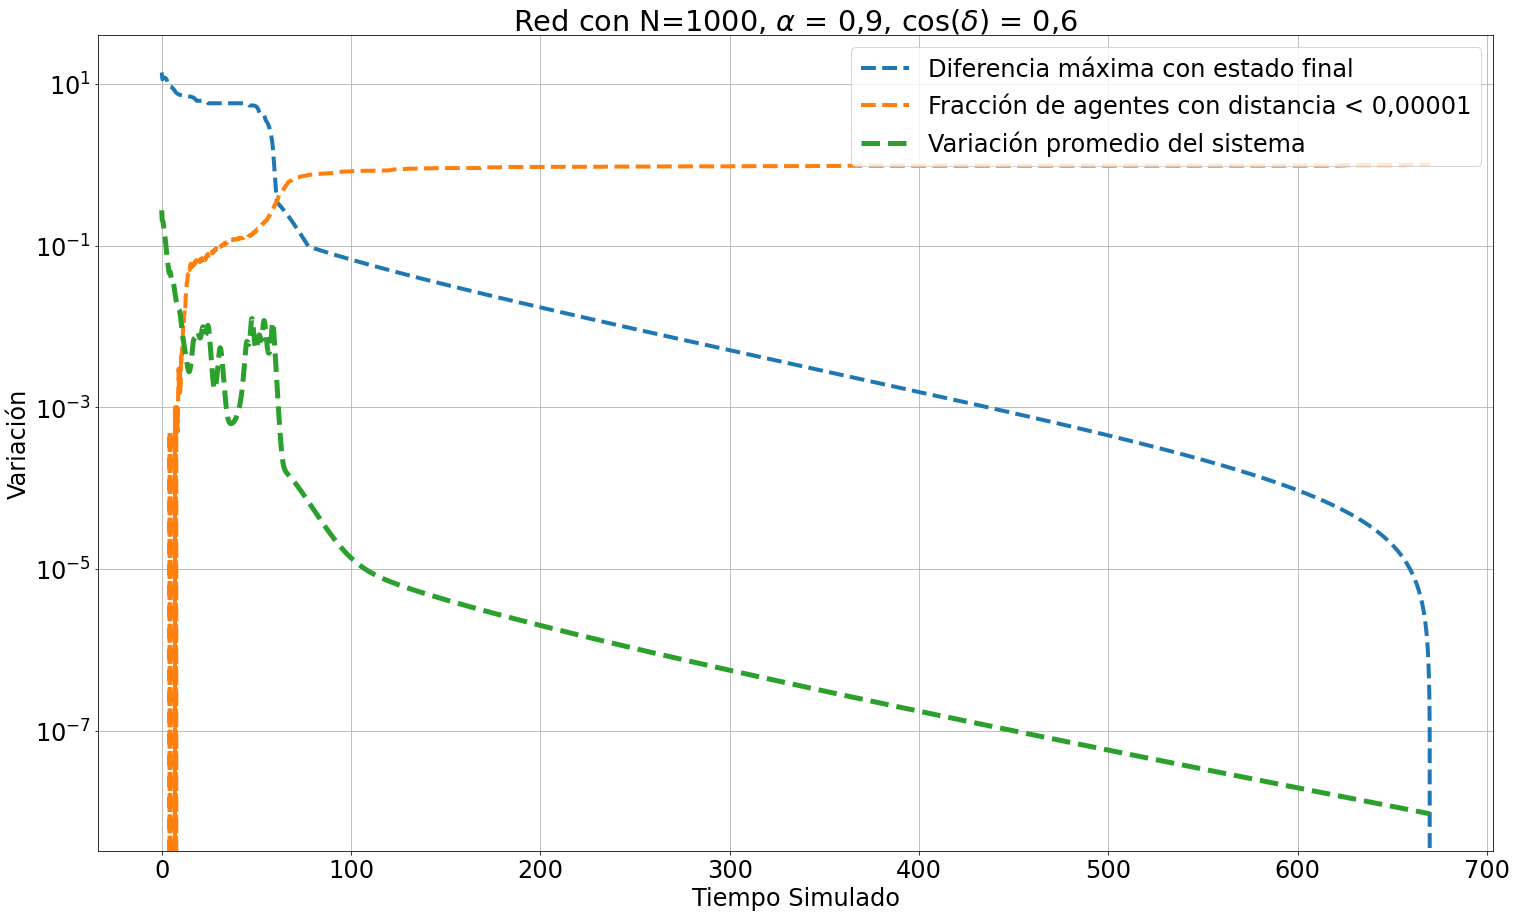

Esto tardó 9.871334791183472 segundos


In [27]:
# Voy a revisar un poco al archivo que tiene una tardanza muy grande
# con respecto al resto de los archivos. Por lo que vi, dió la casualidad
# de que los sujetos estaban enganchados de forma tal que tenían un avance
# muy lento nomás.

t0 = time.time()

#--------------------------------------------------------------------------------------------

# Levanto los datos del archivo original y separo los datos en tres listas.
# Una para la matriz de Adyacencia, una para la matriz de superposición y una para los vectores de opiniones

Datos = ldata("ER2/Datos_Opiniones_alfa=0.900_Cdelta=0.600_N=1000_Iter=2")

Ady = Datos[1][1:len(Datos[1])] # Lista con elementos de la matriz de Adyacencia
Ady = np.array([int(x) for x in Ady])

Sup = Datos[3][1:len(Datos[3])] # Lista con elementos de la matriz de Superposición
Sup = np.array([float(x) for x in Sup])

# Armo mi lista de opiniones con arrays, y me armo una segunda que sea del mismo tamaño que la de
# opiniones, pero que tenga en todas sus filas únicamente la fila de opiniones final.
Opi = np.zeros((len(Datos[5::]),len(Datos[5])-1))
Opi2 = np.zeros((len(Datos[5::]),len(Datos[5])-1))
Filafinal = np.array([float(x) for x in Datos[len(Datos)-1][1::]])
for fila,ifila in zip (Datos[5::],np.arange(len(Datos[5::]))):
    Opi[ifila] = fila[1::]
    Opi2[ifila] = Filafinal

# Me calculo la distancia entre el valor de la opinión en la iteración y el valor final que
# adopta, como para ver si el sistema tiene una variación muy grande dada un sujeto, mientras
# el resto está ya cerca del final.
Y = np.zeros(Opi.shape[0])
for ifila,fila in zip (np.arange(Opi.shape[0]),Opi-Opi2):
    Y[ifila] = max(np.absolute(fila))

# Armo el gráfico
X = np.arange(len(Y))*0.1

plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(25,15))
plt.semilogy(X,Y,"--",linewidth=4, label="Diferencia máxima con estado final")
plt.title(r"Red con N=1000, $\alpha$ = 0,9, cos($\delta$) = 0,6")
plt.xlabel("Tiempo Simulado")
plt.ylabel("Variación")
plt.grid()


#-----------------------------------------------------------------------------------------

# Ahora voy a querer graficar la cantidad de sujetos que tienen una distania menor
# a 0.001. Elijo eso porque la máxima distancia llega a ese valor como entre 400 y 500 de tiempo
# de simulación. Voy a tomar ese número y graficarlo normalizado, para que se vea sobre el gráfico.
# La idea es ver que más o menos todos los agentes caen juntos, y que no es que algunos se quedan rezagados.
# Creo, porque ahora que lo pienso, si 2 o 3 sujetos son el problema, no creo que esto lo muestre.

Y = np.count_nonzero(np.absolute(Opi-Opi2) < 0.00001, axis=1)/2000
X = np.arange(len(Y))*0.1

plt.semilogy(X,Y,"--",linewidth=4, label="Fracción de agentes con distancia < 0,00001")

#---------------------------------------------------------------------------------------------

# Por lo visto, efectivamente parecieran ser unos pocos sujetos los que generan el quilombo.
# Pongamos también la Variación Promedio.

Var = [math.sqrt(np.sum((Opi[i+1]-Opi[i])*(Opi[i+1]-Opi[i])*(1/len(Opi[i])))) for i in range(Opi.shape[0]-1)]
X = np.arange(len(Var))*0.1
plt.semilogy(X,Var, "--", linewidth = 5, label="Variación promedio del sistema")

#----------------------------------------------------------------------------------------------

# Intentemos ubicar cuáles son los sujetos que tienen problema con la evolución de su opinión.
# para eso usemos el np.where

Indice = np.where(np.absolute(Opi-Opi2) > 0.1)

ind = 0
for n in np.arange(len(Indice[0])):
    if np.count_nonzero(Indice[0] == n) <=20:
        break
    ind += np.count_nonzero(Indice[0] == n)

UsualSuspects = Indice[1][ind:ind+np.count_nonzero(Indice[0] == n)]
print(UsualSuspects)
print(Indice[0][ind:ind+np.count_nonzero(Indice[0] == n)])





#----------------------------------------------------------------------------------------------
plt.legend(loc = "upper right")
plt.show()


Tiempo()

In [9]:
t0 = time.time()

# def EstadoFinal(Lista):
    
#     # Tomo la lista y la convierto en array para trabajarla mejor
#     Array = np.array(Lista)
    
#     #----------------------------------------------------------
#     # Primero veo el caso de que hayan tendido a cero
    
#     ArrayAbs = np.absolute(Array)
#     if max(ArrayAbs)<0.1:
#         return "Consenso"
    
#     #----------------------------------------------------------
#     # Ahora veamos los otros dos casos. Primero voy a armar
#     # un array que tenga las opiniones del tópico 1, y otro
#     # con las opiniones del tópico 2.
    
#     ArrayT1 = Array[0:len(Array):2]
#     ArrayT2 = Array[1:len(Array):2]
    
#     ArrayProd = np.multiply(ArrayT1,ArrayT2)
#     for producto in ArrayProd[1:len(ArrayProd)-1]:
#         if producto*ArrayProd[0]<0:
#             return "Polarizacion"
    
#     return "Ideologico"


Tiempo()

[False False False ... False False False]
Esto tardó 0.14491581916809082 segundos


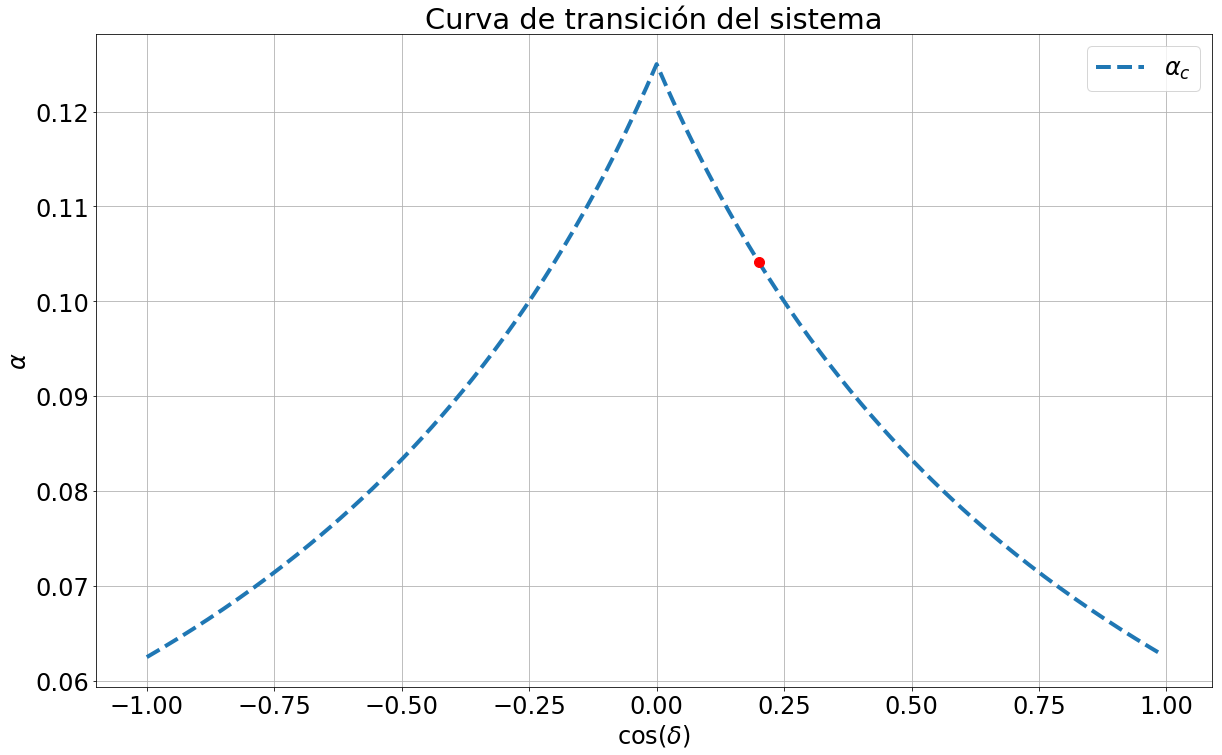

Esto tardó 0.3050534725189209 segundos


In [4]:
t0 = time.time()

# Acá voy a graficar el alfa crítico. Para eso defino primero mi función de AlfaC

def AlfaC(x):
    T = 2 # Número de tópicos
    GM = 8 # Grado medio
    K = 1 # Influencia social
    if(x>0):
        alfa = (T-1)/((GM*K)*(T-1+x))
    else:
        alfa = (T-1)/((GM*K)*(T-1-x))
    return alfa

# Ya probé la función y ahora sí calcula perfecto. Hubo un pequeño
# error al principio.

#------------------------------------------------------------------

# Defino mis vectores a graficar y armo el gráfico

X = np.arange(-1,1,0.01)
Y = np.array([AlfaC(x) for x in X])

plt.figure(figsize=(20,12))
plt.plot(X,Y,"--",linewidth=4, label = r"$\alpha_c$")
plt.plot(0.2,AlfaC(0.2),"or", markersize=10)
plt.rcParams.update({'font.size': 24})
plt.title("Curva de transición del sistema")
plt.xlabel(r"cos($\delta$)")
plt.ylabel(r"$\alpha$")
plt.grid()
plt.legend()
plt.show()



Tiempo()

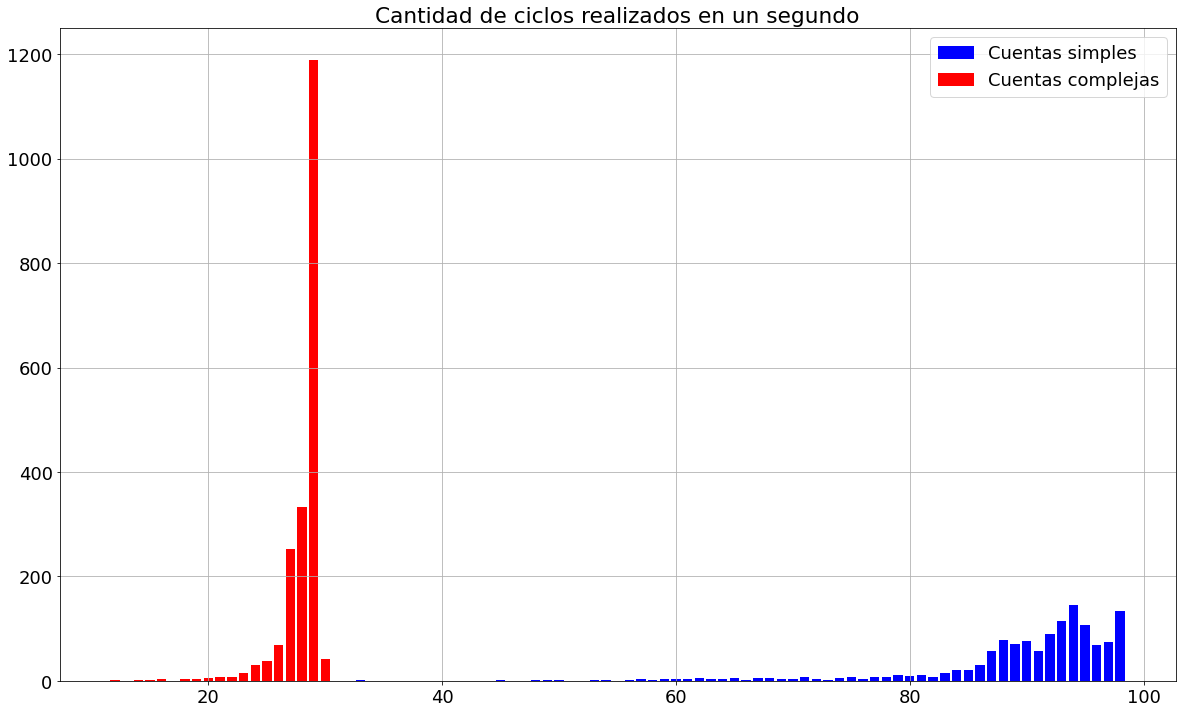

[12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]
[12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]
Esto tardó 0.5427219867706299 segundos


In [3]:
t0 = time.time()

# Acá voy a hacer el histograma de cantidad de ciclos realizados para una serie de cuentas simples
# versus una serie de cuentas complejas. La idea es ver si hay una ganancia de tiempo al realizar
# cuentas simples de multiplicación, división, suma y resta versus cálculos de tanh.

Datos = ldata("Histograma_Ciclos")

Simples = [int(x) for x in Datos[0][1:len(Datos[0])]]
Complejos = [int(x) for x in Datos[1][1:len(Datos[1])]]

Bins = [x for x in range(12,100)]

[Hist1,Bin1] = np.histogram(Simples, bins = Bins)
[Hist2,Bin2] = np.histogram(Complejos, bins = Bins)

plt.figure(figsize=(20,12))

plt.bar(Bin1[0:len(Bin1)-1], Hist1,color = "blue", label = "Cuentas simples")
plt.bar(Bin2[0:len(Bin2)-1], Hist2,color = "red", label = "Cuentas complejas")
plt.rcParams.update({'font.size': 18})
plt.title("Cantidad de ciclos realizados en un segundo")
plt.grid()
plt.legend()
plt.show()

# Al final se puede ver que obviamente hay ganancia, para un mismo intervalo de tiempo, en promedio
# realizo aproximadamente 4 ciclos más con cuentas simples que con cuentas complejas.



Tiempo()

In [15]:
# Acá lo que hay es una función que armé para distribuir un índice que indique el color
# que le corresponde al estado final que alcanza un agente al evolucionar el sistema.

# def Indice_Color(vector,Divisiones):
#     # Primero calculo el ángulo
#     Vhor = [1,0] # Este vector representa la horizontal
#     vector_unitario = vector/np.linalg.norm(vector)
#     Producto_escalar = np.dot(Vhor,vector_unitario)
#     Angulo = np.arccos(Producto_escalar)
    
#     # Le hago ajuste considerando el cuadrante del vector
#     if vector[1] < 0:
#         Angulo = 2*math.pi-Angulo
    
    
#     # Ahora calculo el valor de división entera y el Resto
#     Delta = (2*math.pi)/Divisiones
#     Dividendo = Angulo/Delta
#     D = math.floor(Dividendo)
#     R = Dividendo - D
    
#     # Compruebo en qué casillero cae el ángulo y returneo el índice
#     if R <= Delta/2:
#         return D # En este caso el ángulo se encuentra entre (D*Delta-Delta/2,D*Delta+Delta/2]
#     elif R > Delta/2:
#         return (D+1)%360 # En este caso el ángulo se encuentra entre ((D+1)*Delta-Delta/2,(D+1)*Delta+Delta/2]
    
    
# a = Indice_Color([1,-1/50],360)

A = np.array([1,2,3,4,5,6,7,8,9])
B = np.array([1,1,1,1,1,1,1,1,1])

A-B


array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
# Lo que hay en esta celda es un análisis inútil que hice de mis datos de Error Cuadrático.
# Tan inútil resultó que ahora el Error Cuadrático es la Variación Promedio de las Opiniones.
# Lo voy a guardar acá como para que esté en algún lado ya que está escrito y quizás tiene
# algo que se le pueda rescatar en el futuro.

#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################

t0= time.time()

# En esta celda voy a trabajar por armar un criterio de corte que parezca razonable.
# Estoy dispuesto a ser más liberal que conservador. Es decir, estoy dispuesto a 
# que el sistema corra de más y no de menos.

#--------------------------------------------------------------------------------------------

CarpCheck=[[root,files] for root,dirs,files in os.walk("./Datos Corte")]

# El comentario anterior era considerando que no le daba la dirección correcta
# de la carpeta con mi información al os.walk. Esta vez le estoy pasando la 
# dirección exacta, así que no es necesario hacer tanto quilombo para separar
# los nombres de los archivos. El elemento en la posición x[0] es el nombre de la carpeta

for x in CarpCheck:
    # dada = x[0].split("\\")
    Archivos_Datos = [nombre for nombre in x[1]]
    Archivos_Datos.insert(0,x[0])

# Con esto tengo los nombres de todos los archivos en la carpeta de Datos Corte
# Archivos_Datos tiene en la primer coordenada el principio de la dirección
# de la carpeta, y el resto de elementos son los archivos en la carpeta.
# Entonces si quiero buscar el objeto voy a tener que usar:
# Archivos_Datos[0]/Archivos_Datos[1]

#----------------------------------------------------------------------------

# Tengo dos tipos de archivos. Los de datos de opiniones tienen el siguiente formato:
# Datos_Evolucion_Opinion_N=$_T=$_K=$
# Los de datos de error cuadrático tienen el formato: Datos_Errcuad_DiferenciaOpi_N=$_T=$_K=$
# Armemos dos listas, una con los nombres de las opiniones y otra con los nombres de los errores.
# En ambas listas el primer elemento va a ser la carpeta en la que se encuentran los datos.
# En esta celda voy a armar la lista de Nombres de Errores.
        
Nombres_Errores = [Archivos_Datos[0]]
for nombre in Archivos_Datos[1:len(Archivos_Datos)]:
    if nombre.split("_")[1] == "Errcuad":
        Nombres_Errores.append(nombre)

# Bien, las listas de nombres de archivos ya se arman correctamente

#-------------------------------------------------------------------------------------------

# Como el valor de K para cada batch puede variar, voy a intentar descubrir los valores
# mínimos y máximos de los K involucrados.

Kmin = int(float(Nombres_Errores[1].split("_")[5].split("=")[1]))
Kmax = int(float(Nombres_Errores[1].split("_")[5].split("=")[1]))

# Defino un Kmin y Kmax inicial cualquiera, pero que esté dentro del conjunto total

for nombre in Nombres_Errores[1:len(Nombres_Errores)]:
    K = int(float(nombre.split("_")[5].split("=")[1]))
    Kmin = min(K,Kmin)
    Kmax = max(K,Kmax)

# Bien, esto ya me obtiene los valores de Kmin y Kmax correctamente.
# Acá tenés que tener cuidado, porque originalmente K es un número float.
# En esta ocasión tomé valores de K enteros, pero podría no haberlo hecho.
# Después habrá que corregir eso.

#-------------------------------------------------------------------------------------------
plt.figure(figsize=(20,12))

for influencia in range(Kmin,Kmax+1):
    X0 = [] # Acá voy a guardar los números de agentes
    Y0 = [] # Acá voy a guardar la cantidad de ceros que aparecen en los errores
    X = [] # Acá voy a guardar los números de agentes ordenados
    Y = [] # Acá voy a guardar la cantidad de ceros que aparecen en los errores de manera ordenada

    for nombre in Nombres_Errores[1:len(Nombres_Errores)]:
        
        # Levanto los valores de N, K y T del nombre de mi archivo. Es importante recordar que mis
        # archivos tienen nombres de la forma: Datos_Errcuad_DiferenciaOpi_N=$_T=$_K=$

        N = int(nombre.split("_")[3].split("=")[1])
        T = int(nombre.split("_")[4].split("=")[1])
        K = float(nombre.split("_")[5].split("=")[1])

        # Los valores de N, T y K se levantan correctamente

        #--------------------------------------------------------------------------------------------
        # Reviso que esté mirando los datos que tengan el valor de K que busco antes de graficar.
        if influencia==K:

            # Levanto los datos del archivo original y separo los datos en tres listas.
            # Una para la matriz de Adyacencia, una para la matriz de superposición y una para los vectores de opiniones

            Datos = ldata("{}/{}".format(Nombres_Errores[0],nombre))

            # Lista con elementos de los vectores de opinión. Al final sí había una forma compacta de hacer esto.
            # Si la matriz de Adyacencia evoluciona en el tiempo, va a haber que ver de hacer cambios acá.
            Err = [float(x) for x in Datos[0][1:len(Datos[0])]]

            # Tengo correctamente levantados los datos de los errores

            #--------------------------------------------------------------------------------------------
            
            X0.append(N)
            Y0.append(Err.count(0))
            
    A = [n for n in X0]
    A.sort()
    for n in A:
        i = X0.index(n)
        X.append(X0[i])
        Y.append(Y0[i])
        
    plt.plot(X,Y,"--",label="K={}".format(influencia) ,linewidth = 3)

plt.rcParams.update({'font.size': 18})
plt.xlabel("Agentes")
plt.ylabel("Cantidad de ceros")
plt.title("Cantidad de ceros en los errores según cantidad de agentes y según K")
plt.grid()
plt.legend()
#     plt.savefig("../Imagenes/Estabilizacion/Ceros_vs_Agentes_T={}.png".format(agentes,T),bbox_inches = "tight")
plt.show()


---------------------------------------------------------------------------------------------------

Otra cosa que se me ocurre es graficar algunas líneas horizontales que marquen los valores
del 50%, 40% y así hasta el 10% y 5% del máximo valor de error. Como una forma gráfica de ver
qué parte del gráfico se encuentra en qué regiones.

for nombre in Nombres_Errores[1:len(Nombres_Errores)]:
        
    # Levanto los valores de N y T del nombre de mi archivo. Es importante recordar que mis
    # archivos tienen nombres de la forma: Datos_Errcuad_DiferenciaOpi_N=$_T=$_K=$

    N = int(nombre.split("_")[3].split("=")[1])
    T = int(nombre.split("_")[4].split("=")[1])
    K = float(nombre.split("_")[5].split("=")[1])

    # Los valores de N, T y K se levantan correctamente

    #--------------------------------------------------------------------------------------------

    # Levanto los datos del archivo original y separo los datos en tres listas.
    # Una para la matriz de Adyacencia, una para la matriz de superposición y una para los vectores de opiniones

    Datos = ldata("{}/{}".format(Nombres_Errores[0],nombre))

    # Lista con elementos de los vectores de opinión. Al final sí había una forma compacta de hacer esto.
    # Si la matriz de Adyacencia evoluciona en el tiempo, va a haber que ver de hacer cambios acá.
    Err = [float(x) for x in Datos[0][1:len(Datos[0])]]

    # Tengo correctamente levantados los datos de los errores

    #--------------------------------------------------------------------------------------------

    # Como lo único que tengo que graficar es el Error, ya tengo los datos armados. Sólo necesito
    # un vector X asociado.

    X = np.arange(0,len(Err))

    plt.figure(figsize=(20,12))
    plt.semilogy(X,Err, "--",linewidth = 3)

    plt.axhline(y=max(Err)*0.005,label="0.5%",linewidth=3)

    # Este código de acá para que el sistema vaya cambiando colores de cada recta. Es un código heredado.
    # Lo saqué de Stack Overflow. Me hago la idea de qué hace, pero ni idea de qué son exactamente
    # estas funciones.
    color=cm.rainbow(np.linspace(0,1,10))
    # En el linspace, el tercer número es justamente el número de curvas que vas a graficar.
    # Eso después es la cantidad de números en la que vas a iterar a i en el zip
    for i,c in zip(range(1,11),color):
        plt.axhline(y=max(Err)*0.02*i,label="{}%".format(i*2), c=c ,linewidth=3)

    plt.rcParams.update({'font.size': 18})
    plt.xlabel("Iteraciones")
    plt.ylabel("Suma de diferencias cuadradas")
    plt.title("Umbrales de valor de error para sitema de N={} K={}".format(N,K))
    plt.grid()
    plt.legend()
#     plt.savefig("../Imagenes/Umbrales Error/Umbrales_N={}_T={}_K={}.png".format(N,T,K),bbox_inches = "tight")
    plt.close()


Tiempo()